In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time as time_lib
from scipy.integrate import solve_ivp
from scripts.network import network
from scripts.training import trainModel
from scripts.dynamics import vecField,vecField_np
from scripts.parareal import parallel_solver
from scripts.ode_solvers import solver
from scripts.plotting import plot_results

In [2]:
torch.manual_seed(1)
np.random.seed(1)
dtype=torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
system = "SIR"

vecRef = vecField_np(system=system)

if system=="SIR":
        beta,gamma,N = vecRef.beta,vecRef.gamma,vecRef.N
        t_max = 100.
        num_t = 101
        L = 3
        n_t = 2
        vecRef.dt_fine = 1e-2
elif system=="Brusselator":
        A,B = vecRef.A,vecRef.B 
        t_max = 12.
        num_t = 25
        L = 3
        n_t = 5
        vecRef.dt_fine = t_max/640
else:
        print("Dynamics not implemented")

In [4]:
if system=="SIR":
        y0 = np.array([0.3,0.5,0.2])
        d = 3
elif system=="Brusselator":
        y0 = np.array([0.,1.])
        d = 2
else:
        print("Dynamics not implemented")

In [5]:
#Domain details
t0 = 0. #initial time
    
import pickle
with open('trainedModels/trained_model_SIR_20240327_122214.pkl', 'rb') as f:
    params = pickle.load(f)
    
dt = params["dt"] / 2
nlayers = params["nlayers"]
hidden_nodes = params["hidden_nodes"]
act = params["act"]
dim_t = params["dim_t"]
device = params["device"]
file_name = params["file_name"]

model = network(neurons=hidden_nodes,d=d,dt=dt,act_name=act,nlayers=nlayers,dtype=dtype,system=system) #If you want a different network
model.to(device);

model.load_state_dict(torch.load(f"trainedModels/{file_name}.pt",map_location=device))
model.eval();

In [6]:
data = {"y0" : y0,
        "system" : system,
        "device":device,
        "dtype":dtype}

In [7]:
number_points = int(t_max / dt)
time = np.linspace(0,100,number_points+1)
dts = np.diff(time)

In [8]:
num_processors_list = [1]#np.arange(1,8)
computational_times = []
overheads = []
used_processors = []
for number_processors in num_processors_list:
    print(f"Experiment with {number_processors} processors")
    coarse_values_parareal,networks, total_time, number_processors, overhead_costs = parallel_solver(time,data,dts,vecRef,number_processors,model,verbose=True)
    used_processors.append(number_processors)
    overheads.append(overhead_costs)
    computational_times.append(total_time)

Experiment with 1 processors
Average cost first iterate :  0.00029980897903442383


Time for iterate 1 is 0.059961795806884766


Time required for the fine solver at iterate 2:  0.2799689769744873 


Solution time for the fine integrator : 0.2782914638519287
Overhead cost : 0.0016775131225585938


Norms differences :  [0.00000000e+00 2.67922662e-05 4.86706468e-05 6.51560932e-05
 7.66196778e-05 8.40327978e-05 8.89443841e-05 9.33348782e-05
 9.94113988e-05 1.08860861e-04 1.22357995e-04 1.39806987e-04
 1.60451565e-04 1.83263411e-04 2.07422813e-04 2.32239974e-04
 2.57209398e-04 2.81912233e-04 3.06187896e-04 3.29758657e-04
 3.52584675e-04 3.74570535e-04 3.95723676e-04 4.16053041e-04
 4.35501542e-04 4.54113922e-04 4.71822291e-04 4.88745061e-04
 5.04740163e-04 5.19871286e-04 5.34104887e-04 5.47480887e-04
 5.59873496e-04 5.71383329e-04 5.81965081e-04 5.91672177e-04
 6.00501373e-04 6.08575223e-04 6.15945203e-04 6.22699790e-04
 6.28808751e-04 6.34538220e-04 6.39952569e-04 6.45149694e-04
 6.503854

In [9]:
if len(num_processors_list)>1:
    fig = plt.figure(dpi=600)
    plt.plot(num_processors_list,computational_times,'ko')
    plt.xlabel("Number of processors")
    plt.ylabel("Computational time")
    plt.savefig(f"savedPlots/comparison_costVSprocessors_{system}.pdf")
    
    for i in range(len(num_processors_list)):
        plt.plot(num_processors_list[i],overheads[i],'r-o')
    plt.title("Overhead costs")
    plt.xlabel("Number processors")
    plt.ylabel("Cost")

In [10]:
def get_detailed_solution():
    num_steps = int((dts[0] / vecRef.dt_fine))
    time_plot = np.linspace(0,dts[0],num_steps)
    sol = model.plotOverTimeRange(y0,time_plot,data)
    total_time = time_plot
    for i in np.arange(len(dts)):
        num_steps = int((dts[i] / vecRef.dt_fine))
        time_plot = np.linspace(0,dts[i],num_steps)[1:]
        sol = np.concatenate((sol,model.plotOverTimeRange(coarse_values_parareal[i+1],time_plot,data)),axis=1)
        total_time = np.concatenate((total_time,time_plot+total_time[-1]),axis=0)
    return sol,total_time

In [11]:
network_sol, time_plot = get_detailed_solution()

In [12]:
initial = time_lib.time()
arg = [[y0,time_plot[-1],time_plot],vecRef]
output,time_plot_sequential = solver(arg,final=False)
#output, _ = dop853(funcptr, y0, t_eval=time_plot, rtol=1e-11, atol=1e-10)
final = time_lib.time()
print(f"Computational time sequential: {final-initial}")
print(f"Computational time parallel with {number_processors} processors: {total_time}")

Computational time sequential: 0.25399088859558105
Computational time parallel with 1 processors: 1.0154249668121338


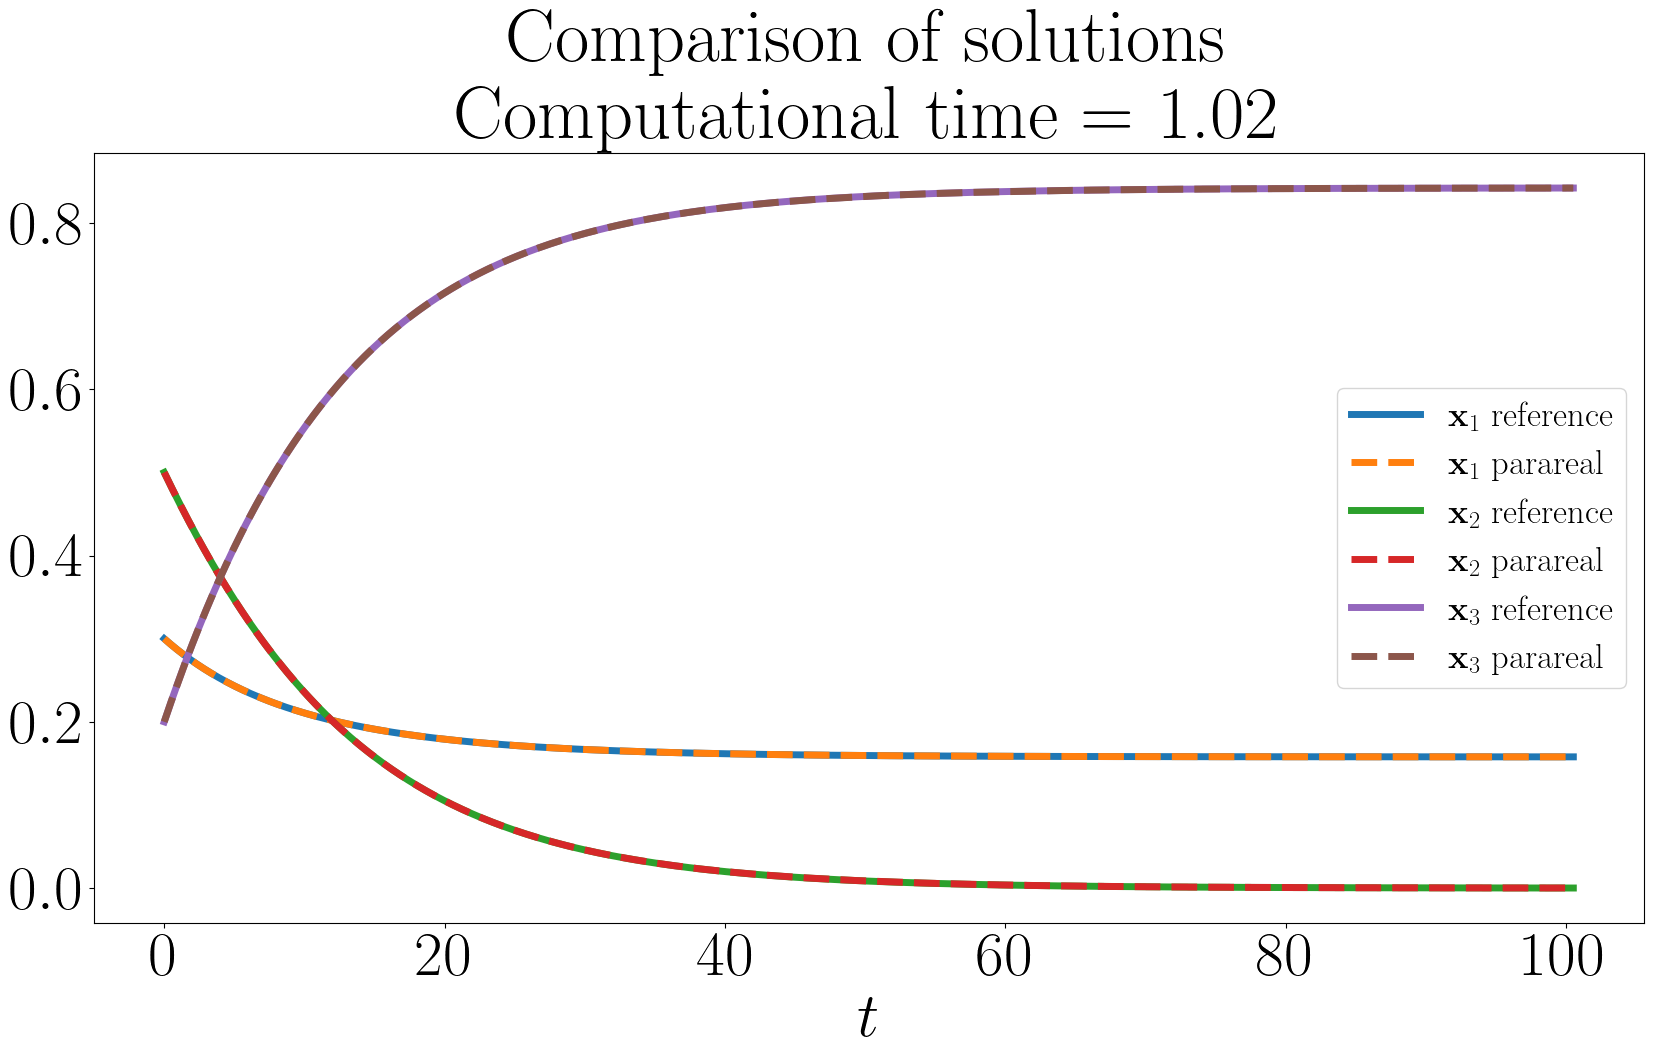

In [13]:
if len(y0)==2:
        list_of_labels = [r"$\mathbf{x}_1$",r"$\mathbf{x}_2$"]
elif len(y0)==3:
        list_of_labels = [r"$\mathbf{x}_1$",r"$\mathbf{x}_2$",r"$\mathbf{x}_3$"]
elif len(y0)==4:
        list_of_labels = [r"$\mathbf{x}_1$",r"$\mathbf{x}_1'$",r"$\mathbf{x}_2$",r"$\mathbf{x}_2'$"]
else:
        list_of_labels = []
plot_results(y0,system,time_plot,time_plot_sequential,output,network_sol,list_of_labels,total_time,time)